In [1]:
import os
import sys
from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
import tqdm
from abc import ABCMeta, abstractmethod, abstractproperty
from copy import copy
%matplotlib inline
plt.style.use("ggplot")
%load_ext autoreload
%autoreload 2

## Exercise 4.7(1)

In [2]:
class PoissonDistribution(object):
    def __init__(self,ramda,random_state = random.randint(0,1000)):
        self.ramda = ramda
        self.rng = np.random.RandomState(random_state)
        
    def get_random(self):
        randsum = self.rng.random()
        
        currentsum = 0
        n = 0
        while True:
            currentsum += (self.ramda ** n) / np.math.factorial(n) * np.exp(-self.ramda)
            if currentsum > randsum:
                return n
            n += 1
    
    def get_distribution(self,limit=10):
        retprobs = []
        for n in range(limit):
            prob = (self.ramda ** n) / np.math.factorial(n) * np.exp(-self.ramda)
            retprobs.append(prob)
        return retprobs

In [ ]:
class FiniteMDP(object):
    def __init__(self,states,actions,rewards,dynamics):
        self.states = states
        self.actions = actions
        self.rewards = rewards
        self.dynamics = dynamics
    
    def simplify(self):
        sim_dynamics = {}
        for one_state in tqdm.tqdm(self.dynamics):
            sim_dynamics[one_state] = {}
            for one_action in self.dynamics[one_state]:
                dynamic_dic = {}
                prob_dic = {}
                
                sim_dynamics[one_state][one_action] = dynamic_dic
                
                for (next_state,reward),prob in self.dynamics[one_state][one_action].items():
                    dynamic_dic.setdefault(next_state,0)
                    dynamic_dic[next_state] += reward * prob
                    prob_dic.setdefault(next_state,0)
                    prob_dic[next_state] += prob
                            
                for next_state in list(dynamic_dic.keys()):
                    avg_reward = dynamic_dic[next_state] / prob_dic[next_state]
                    dynamic_dic[next_state,avg_reward] = prob_dic[next_state]
                    del dynamic_dic[next_state]
        return FiniteMDP(copy(self.states),copy(self.actions),copy(self.rewards),sim_dynamics)

class MDPEnv(metaclass=ABCMeta):
    def __init__(self):
        pass
    
    @abstractmethod
    def get_states(self):
        pass
    
    @abstractmethod
    def get_actions(self):
        pass
    
    @abstractmethod
    def get_rewards(self):
        pass

    @staticmethod
    def get_dynamics(self):
        pass
    
    def get_mdp(self):
        states = self.get_states()
        actions = self.get_actions()
        rewards = self.get_rewards()
        dynamics = self.get_dynamics()
        return FiniteMDP(states,actions,rewards,dynamics)
    
class CarRentalEnv(MDPEnv):
    def __init__(self,request_1=3,request_2=4,return_1=3,return_2=2,car_maxnumber=20,carmove_fee=2,max_carmove=5,rental_fee=10):
        self.request_1_dis = PoissonDistribution(request_1).get_distribution()
        self.request_2_dis = PoissonDistribution(request_2).get_distribution()
        
        self.return_1_dis = PoissonDistribution(return_1).get_distribution()
        self.return_2_dis = PoissonDistribution(return_2).get_distribution()
        
        self.car_maxnumber = car_maxnumber
        self.carmove_fee = carmove_fee
        self.max_carmove = max_carmove
        self.rental_fee = rental_fee
    
    def get_states(self):
        return [i for i in range((self.car_maxnumber + 1) * (self.car_maxnumber + 1))]
    
    def get_actions(self):
        return list(range(-self.max_carmove,self.max_carmove + 1))
    
    def get_rewards(self):
        # 这个reward种类着实有点多啊，先不遍历
        pass
    
    def get_state_dynamics(self,state,carmoved):
        state2ab = lambda s:divmod(s,self.car_maxnumber + 1)
        ab2state = lambda a,b: a * (self.car_maxnumber + 1) + b
        
        reward_movecar = -self.carmove_fee * carmoved
        
        reward_tostate_prob = {}
        a_num,b_num = state2ab(state)
        #assert(a_num <= self.car_maxnumber and b_num <= self.car_maxnumber)
        for request_1,request_1_prob in enumerate(self.request_1_dis):
            for return_1,return_1_prob in enumerate(self.return_1_dis):
                for request_2,request_2_prob in enumerate(self.request_2_dis):
                    for return_2,return_2_prob in enumerate(self.return_2_dis):
                        reward_1 = min(request_1,a_num) * self.rental_fee
                        reward_2 = min(request_2,b_num) * self.rental_fee
                        
                        remain_1 = a_num - min(request_1,a_num) + return_1
                        remain_2 = b_num - min(request_2,b_num) + return_2
                        remain_1 = min(remain_1,self.car_maxnumber)
                        remain_2 = min(remain_2,self.car_maxnumber)
                        
                        assert(remain_1 >= 0 and remain_2 >= 0)
                        
                        nextstate = ab2state(remain_1,remain_2)
                        total_reward = reward_movecar + reward_1 + reward_2
                        
                        reward_tostate_prob.setdefault((nextstate,total_reward),0)
                        reward_tostate_prob[(nextstate,total_reward)] += request_1_prob * request_2_prob * return_1_prob * return_2_prob
        return reward_tostate_prob
        
    def get_dynamics(self):
        state2ab = lambda s:divmod(s,self.car_maxnumber + 1)
        ab2state = lambda a,b: a * (self.car_maxnumber + 1) + b
        
        dynamics = {}
        
        for one_state in tqdm.tqdm(range((self.car_maxnumber + 1) * (self.car_maxnumber + 1))):
            dynamics[one_state] = {}
            a_num,b_num = state2ab(one_state)
            for one_action in self.get_actions():
                a2bnum = one_action
                if a2bnum > a_num or - a2bnum > b_num:
                    continue
                
                dynamics[one_state][one_action] = {}
                
                # a2bnum为正时为从a到b移动车辆，反之为从b到a
                a_moved_num,b_moved_num = a_num - a2bnum,b_num + a2bnum
                assert(a_moved_num >= 0 and b_moved_num >= 0)
                to_state = ab2state(a_moved_num,b_moved_num)
                
                dynamics[one_state][one_action] = self.get_state_dynamics(to_state,np.abs(a2bnum))
        return dynamics
    

In [4]:
carRentalEnv = CarRentalEnv()

In [5]:
mdp = carRentalEnv.get_mdp()
dynamics = mdp.dynamics

100%|██████████| 441/441 [02:37<00:00,  2.81it/s]


In [6]:
mdp_simplify = mdp.simplify()
dynamics_simplify = mdp_simplify.dynamics

100%|██████████| 441/441 [00:32<00:00, 13.41it/s]


In [7]:
class PolicyIterationSolver(object):
    def __init__(self,mdp,ramda=0.9):
        self.mdp = mdp
        self.dynamics = self.mdp.dynamics
        self.states = self.mdp.states
        
        self.actions = self.mdp.actions
        self.action2ind = dict(zip(self.actions,list(range(len(self.actions)))))
        self.ind2action = dict(zip(list(range(len(self.actions))),self.actions))
        
        assert(0 in self.actions)
        
        self.Q_values = np.zeros([len(self.states),len(self.actions)],dtype=np.float)
        self.strategy = np.zeros(len(self.states),dtype=np.int)
        self.ramda = ramda
        
    def policy_evaluation_iter(self):
        delta = 0
        for one_state in self.states:
            for one_action in self.dynamics[one_state]:
                action_ind = self.action2ind[one_action]
                q = self.Q_values[one_state][action_ind]
                
                new_q = 0
                # TODO 看看这里有没有bug
                for (next_state,reward),prob in self.dynamics[one_state][one_action].items():
                    new_q += (
                            prob * (reward + self.ramda * self.Q_values[next_state,self.action2ind[self.strategy[next_state]]])
                        )
                delta = max(delta,np.abs(q - new_q))
                self.Q_values[one_state][action_ind] = new_q
        return delta
    
    def policy_evaluation(self,eps=0.1,max_step=100):
        for one_step in range(max_step):
            delta = self.policy_evaluation_iter()
            print("delta for step {}: {}".format(one_step + 1,delta))
            if delta < eps:
                break
    
    def policy_improvement(self):
        policy_stable = True
        
        for one_state in self.states:
            old_action = self.strategy[one_state]
            
            new_action = None
            max_q = -np.inf
            for one_action in self.dynamics[one_state]:
                action_ind = self.action2ind[one_action]
                qsa = self.Q_values[one_state][action_ind]
                if qsa > max_q:
                    max_q = qsa
                    new_action = one_action
            assert(new_action is not None)
            if new_action != old_action:
                policy_stable = False
            self.strategy[one_state] = new_action
        return policy_stable
    
    def solve(self,steps=100):
        current_step = 0
        while current_step < steps:
            current_step += 1
            print("Evaluating,step {}".format(current_step))
            self.policy_evaluation()
            policy_stable = self.policy_improvement()
            print("Improved,step {}".format(current_step))
            if policy_stable:
                break

In [8]:
pis = PolicyIterationSolver(mdp_simplify)

In [9]:
pis.solve(100)

Evaluating,step 1
delta for step 1: 218.1057968975199
delta for step 2: 156.62599029853484
delta for step 3: 91.25370244457719
delta for step 4: 63.63560638107518
delta for step 5: 49.7508246166214
delta for step 6: 38.10887805213747
delta for step 7: 29.343617957687286
delta for step 8: 22.945149327787817
delta for step 9: 18.880768982070776
delta for step 10: 15.601811185734618
delta for step 11: 12.857391621745649
delta for step 12: 10.569213509213284
delta for step 13: 8.667883923962677
delta for step 14: 7.093135923084162
delta for step 15: 5.792969996137572
delta for step 16: 4.722689644389391
delta for step 17: 3.844049172027667
delta for step 18: 3.1245051688426884
delta for step 19: 2.5365344881808483
delta for step 20: 2.0569996046215238
delta for step 21: 1.6665585461769865
delta for step 22: 1.3491234165542778
delta for step 23: 1.0913719596189821
delta for step 24: 0.8823143808916143
delta for step 25: 0.7129149427040602
delta for step 26: 0.5757656448821535
delta for step

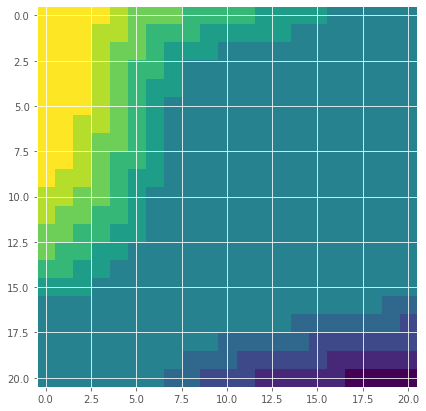

In [10]:
plt.figure(figsize=(7,7))
plt.imshow(np.asarray(pis.strategy).reshape(21,21)[::-1])

## Exercise 4.7(2)

In [11]:
class ModCarRentalEnv(CarRentalEnv):
    def __init__(self,a2bfree=1,second_parking_fee=4,second_parking_threshold=10):
        super().__init__()
        self.a2bfree = a2bfree
        self.second_parking_fee = second_parking_fee
        self.second_parking_threshold = second_parking_threshold
    
    def get_state_dynamics(self,state,carmoved):
        state2ab = lambda s:divmod(s,self.car_maxnumber + 1)
        ab2state = lambda a,b: a * (self.car_maxnumber + 1) + b
        
        reward_movecar = -self.carmove_fee * carmoved
        # 特殊规则1 Jack‘s employee
        if carmoved == 1:
            reward_movecar = 0
        
        reward_tostate_prob = {}
        a_num,b_num = state2ab(state)
        #assert(a_num <= self.car_maxnumber and b_num <= self.car_maxnumber)
        for request_1,request_1_prob in enumerate(self.request_1_dis):
            for return_1,return_1_prob in enumerate(self.return_1_dis):
                for request_2,request_2_prob in enumerate(self.request_2_dis):
                    for return_2,return_2_prob in enumerate(self.return_2_dis):
                        reward_1 = min(request_1,a_num) * self.rental_fee
                        reward_2 = min(request_2,b_num) * self.rental_fee
                        
                        remain_1 = a_num - min(request_1,a_num) + return_1
                        remain_2 = b_num - min(request_2,b_num) + return_2
                        remain_1 = min(remain_1,self.car_maxnumber)
                        remain_2 = min(remain_2,self.car_maxnumber)
                        
                        assert(remain_1 >= 0 and remain_2 >= 0)
                        
                        # 特殊规则2 second parking lot
                        reward_parking = 0
                        if remain_1 > self.second_parking_threshold:
                            reward_parking -= self.second_parking_fee
                        if remain_2 > self.second_parking_threshold:
                            reward_parking -= self.second_parking_fee
                        
                        nextstate = ab2state(remain_1,remain_2)
                        total_reward = reward_movecar + reward_1 + reward_2 + reward_parking
                        
                        reward_tostate_prob.setdefault((nextstate,total_reward),0)
                        reward_tostate_prob[(nextstate,total_reward)] += request_1_prob * request_2_prob * return_1_prob * return_2_prob
        return reward_tostate_prob
    

In [12]:
modCarRentalEnv = ModCarRentalEnv()

In [13]:
mod_mdp = modCarRentalEnv.get_mdp()
mod_dynamics = mod_mdp.dynamics

mod_mdp_simplify = mod_mdp.simplify()
mod_dynamics_simplify = mod_mdp_simplify.dynamics

100%|██████████| 441/441 [00:29<00:00, 14.86it/s]


In [15]:
mod_pis = PolicyIterationSolver(mod_mdp_simplify)
mod_pis.solve(100)

Evaluating,step 1
delta for step 1: 197.47122672499938
delta for step 2: 144.34917829285243
delta for step 3: 84.52877414119607
delta for step 4: 61.724082688387824
delta for step 5: 48.50339080539561
delta for step 6: 37.19069812693567
delta for step 7: 28.59892810079424
delta for step 8: 22.308565754000256
delta for step 9: 18.355091338239646
delta for step 10: 15.116113205895488
delta for step 11: 12.42031099180872
delta for step 12: 10.18373232049521
delta for step 13: 8.333236200870317
delta for step 14: 6.806248840531964
delta for step 15: 5.549508072344167
delta for step 16: 4.517777842130442
delta for step 17: 3.672747748723623
delta for step 18: 2.9821012277599266
delta for step 19: 2.418704128517959
delta for step 20: 1.9598826563446323
delta for step 21: 1.5867769589060572
delta for step 22: 1.2837653539274356
delta for step 23: 1.037956696355593
delta for step 24: 0.8387479868870287
delta for step 25: 0.6774431098858713
delta for step 26: 0.546927510285343
delta for step 27

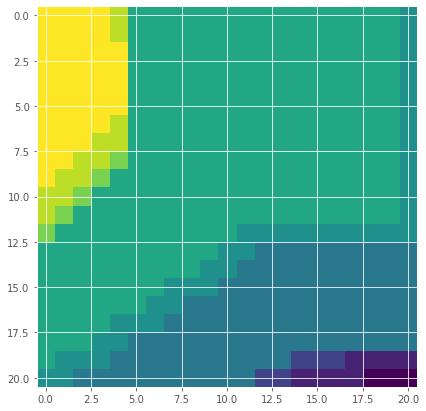

In [16]:
plt.figure(figsize=(7,7))
plt.imshow(np.asarray(mod_pis.strategy).reshape(21,21)[::-1])